<a href="https://colab.research.google.com/github/SandhiyaAcharya/Emotion_Analysis/blob/main/Emotion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

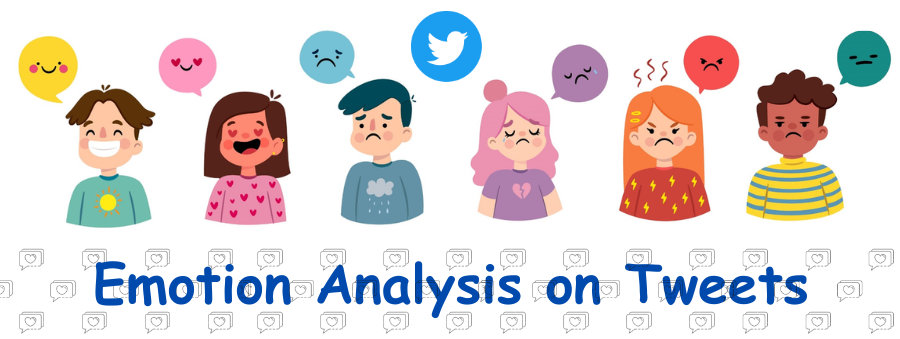

In [64]:
!pip install neattext

In [65]:
!pip install textblob

## Import Libraries

In [66]:
import pandas as pd
import seaborn as sns
import neattext as nt
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import re
from textblob import TextBlob

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
#Load dataset
data=pd.read_csv("/content/text_emotion.csv")
data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [68]:
data.shape

(40000, 4)

## **Data Cleaning**

In [69]:
#Renaming the column name
data.rename(columns={"sentiment": "emotion"}, inplace=True)

In [70]:
data.head()

,tweet_id,emotion,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [71]:
data.isnull().sum()

tweet_id    0
emotion     0
author      0
content     0
dtype: int64

In [72]:
#Removing the empty string from “emotion” and eliminating zeros from the “content” .
data = data[data["emotion"].str.contains("empty") == False]
data = data[data["content"].str.contains("0") == False]

In [73]:
data.head()

,tweet_id,emotion,author,content
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...


In [74]:
(data['content']==0).sum()

0

In [75]:
data['emotion'].unique()

array(['sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', 'love',
       'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

[Text(0, 0, 'sadness'),
 Text(1, 0, 'enthusiasm'),
 Text(2, 0, 'neutral'),
 Text(3, 0, 'worry'),
 Text(4, 0, 'surprise'),
 Text(5, 0, 'love'),
 Text(6, 0, 'fun'),
 Text(7, 0, 'hate'),
 Text(8, 0, 'happiness'),
 Text(9, 0, 'boredom'),
 Text(10, 0, 'relief'),
 Text(11, 0, 'anger')]

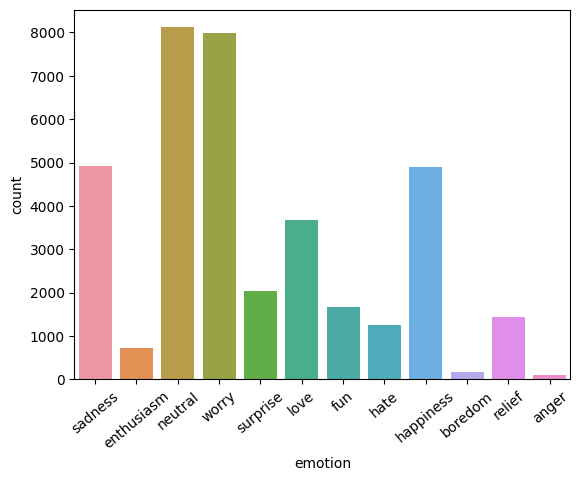

In [76]:
emotions_count=sns.countplot(x='emotion',data=data)
emotions_count.set_xticklabels(emotions_count.get_xticklabels(), rotation=40)

## **Text Processing**

**Lowercasing -  Convert all text to lowercase. This ensures uniformity and helps in reducing the dimensionality of the data.**

In [77]:
data['content']=data['content'].str.lower()
data.head()

,tweet_id,emotion,author,content
1,1956967666,sadness,wannamama,layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends soon!
4,1956968416,neutral,xkilljoyx,@dannycastillo we want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,re-pinging @ghostridah14: why didn't you go to...


**Handling HTML Tags, emojis, emails and URLs- If dealing with web data then remove HTML tags, URLS, emojis, emails.**

In [78]:
data['content']=[nt.remove_html_tags(text) for text in data['content']]
data['content']=[nt.remove_urls(text) for text in data['content']]
data['content']=[nt.remove_emojis(text) for text in data['content']]
data['content']=[nt.remove_emails(text) for text in data['content']]


**Removing Special Characters and Numbers - Remove any non-alphabetic characters and numbers. These often do not contribute to the semantics of the text.**

In [79]:
# Use regular expression to remove non-alphabetic characters and numbers
# def remove_special_chars_and_numbers(text):
#     cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
#     return cleaned_text
# data['content']=[remove_special_chars_and_numbers(text) for text in data['content']]
# data.head()


#Using NeatText
data['content']=[nt.remove_special_characters(text) for text in data['content']]
data['content']=[nt.remove_numbers(text) for text in data['content']]


**Handling Contractions - Expand contractions (e.g., "can't" to "cannot")**

In [80]:
data['content']=[nt.fix_contractions(text) for text in data['content']]

**Removing Punctuation - Remove all punctuation marks (e.g., periods, commas, exclamation marks) as they generally do not carry much information for many NLP tasks.**



In [81]:
# Using regular expression to remove punctuation
# def remove_punctuation(text):
#     cleaned_text = re.sub(r'[^\w\s]', '', text)
#     return cleaned_text
# data['content']=[remove_punctuation(text) for text in data['content']]
# data.head()

#Using NeatText
data['content']=[nt.remove_punctuations(text) for text in data['content']]

**Removing Stopwords-  Remove common, low-information words (e.g., "and", "the", "in") known as stopwords.**

In [82]:
data['content']=[nt.remove_stopwords(text) for text in data['content']]

**Spell Checking - Correct misspelled words using a spellchecker module.**

In [83]:
from textblob import TextBlob
data['content'][:10000] = data['content'][:10000].apply(lambda x: str(TextBlob(x).correct()))


<ipython-input-83-cf3c7f91e0df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['content'][:10000] = data['content'][:10000].apply(lambda x: str(TextBlob(x).correct()))


**Removing Stopwords-  Remove common, low-information words (e.g., "and", "the", "in") known as stopwords.**

In [84]:
data['content']=[nt.remove_stopwords(text) for text in data['content']]

**Tokenization- Split the text into individual words or tokens. This makes it easier to analyze and process.**

In [85]:
data['content']=[word_tokenize(text) for text in data['content']]


In [86]:
data['content'].head()

1          [laying, n, bed, headache, ughhhhwaitin]
2                 [funeral, ceremonygloomy, friday]
3                      [wants, hang, friends, soon]
4    [dannycastillo, want, trade, houston, tickets]
5          [ringing, ghostridah, bc, like, friends]
Name: content, dtype: object

<!-- Lemmatization- Reduce words to their base or root form. This helps in reducing the dimensionality of the feature space. -->